In [1]:
import LinearAlgebra
LA = LinearAlgebra

include("mplstyle.jl");

# Exercise 2.1

In [2]:
A = [1 2 3; 4 5 6; 7 8 9]
x = [2; 4; 0]
y = [5; 7; 1]

3-element Vector{Int64}:
 5
 7
 1

In [3]:
x'*A*y

288

# Exercise 2.2

Find the inverse of matrix B

In [4]:
B = [3 0 2; 2 0 -2; 0 1 1]

3×3 Matrix{Int64}:
 3  0   2
 2  0  -2
 0  1   1

In [5]:
B_inv = LA.inv(B)

3×3 Matrix{Float64}:
  0.2   0.2  -0.0
 -0.2   0.3   1.0
  0.2  -0.3   0.0

In [6]:
B_inv * B

3×3 Matrix{Float64}:
 1.0  0.0  -5.55112e-17
 0.0  1.0   0.0
 0.0  0.0   1.0

In [7]:
B^-1

3×3 Matrix{Float64}:
  0.2   0.2  -0.0
 -0.2   0.3   1.0
  0.2  -0.3   0.0

# Exercise 2.3: Taylor Expansion

In [8]:
f(x) = exp(0.1*x[1]) + log(x[2])

∇f(x) = [0.1*exp(0.1*x[1]); 1/x[2]]
H(x) = [0.01*exp(0.1*x[1]) 0;
        0  -x[2]^(-2)]

# Taylor approximation around the point a
## x,a are supposed to be vectors
f_approx(x,a) = f(a) + (x-a)'*∇f(a)+0.5*(x-a)'*H(a)*(x-a)

f_approx (generic function with 1 method)

In [9]:
# result of analytical Taylor approximation around the point a = [0; 1]
f_approx_a(x) = 0.005*x[1]^2 - 0.5* x[2]^2 + 0.1*x[1] + 2*x[2] - 0.5

f_approx_a (generic function with 1 method)

In [10]:
# Test if analytical solution agrees with the more generic definition of the Taylor approximation
a = [0; 1]
x0 = [10; 5]
@assert f_approx(x0,a) - f_approx_a(x0) < 0.01

In [11]:
# create points for which the functions will be plotted

n = 30 # number of points per dimension

x1_plot = range(-1, 1, length = n)
x2_plot = range(0.1, 2, length = n)

f_plot = [f([x1,x2]) for x1 = x1_plot, x2 = x2_plot]
f_approx_plot = [f_approx([x1,x2],a) for x1 = x1_plot, x2 = x2_plot]

# create grid points
xgrid = repeat(x1_plot',n,1)
ygrid = repeat(x2_plot,1,n)

# allow window to open for interactions
using3D()
pygui(true);
fig = figure("pyplot_surfaceplot",figsize=(15,10))
ax = fig.add_subplot(1,1,1,projection="3d")

plot_surface(xgrid, ygrid, f_plot, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.7, linewidth=0.25)
scatter3D(a[1],a[2],f(a), color = "black", s = 50, zorder = 3)
plot_surface(xgrid, ygrid, f_approx_plot, rstride=2,edgecolors="k", cstride=2, alpha=0.7, linewidth=0.25)

xlabel(L"x_1")
ylabel(L"x_2")
zlabel(L"f(x_1,x_2)")
title("Surface Plot")

PyObject Text(0.5, 1.0, 'Surface Plot')

# Exercise 2.4
Implement the backtracking line search algorithm.

In [22]:
# f: objective function
# ∇f: gradient of the objective function
# x: current point
# d: step direction
# p: step size reduction p∈(0,1)
# β: minimum downward slope is -β∇f(x)

function linesearch(f, ∇f, x, d; p=0.5, β = 1.0*10^-4)
    # initialize step length factor
    α = 1.0   
    
    # ======================================================
    # implement the while loop where α is reduced by p using the Armijo Condition as stopping criterion
    
    # update step length until Armijo Condition is fulfilled
    while f(x + α*d) >  f(x) + β * ∇f(x)' * (α*d)
        α = α*p
    end
    # ======================================================
    
    return α
end;

# Exercise 2.5
Implement the gradient descent algorithm

In [23]:
# f: objective function
# ∇f: gradient of the objective function
# x0: initial point
# ε: stopping criterion on the norm of the gradient
# maxiters: max numbers of gradient descent steps

function gradient_descent(f, ∇f, x0; ϵ=0.0001, maxiters = 1000, p = 0.5)
    # make a copy of initial point to prevent changing x0 by manipulating x
    x = copy(x0)
    
    # store initial point and evaluated function at initial point 
    trace = [x; f(x)]
    for _=1:maxiters
        
        # ======================================================
        # 1. evaluate the descent step direction at the point x
        d = -∇f(x)
        # 2. check if norm of the gradient is close enough to zero (use precision of ϵ). If yes break from the
        #    loop.
        if LA.norm(d) < ϵ
            break
        end
        # 3. Evaluate the next point x by stepping into the descent direction.
        #    Use the result of the backtracking linesearch to guarantee convergence.
        x += linesearch(f, ∇f, x, d, p = p) * d
        
        # ======================================================
        
        trace = hcat(trace,[x; f(x)])
        
        # check if the function value became smaller
        @assert trace[end,end] <= trace[end,end-1]
    end
    return x,trace
end;

# Exercise 2.6

Test your implementation at the _marathon training example_ treated in lectures 1 and 2.

Use gradient descent in combination with backtracking line search to fit a linear model to the data from a training for a marathon.

<img src="figures/laufbahn.jpeg" width="350">

We train for a Marathon and measure the covered distance every 10 min. We train only for 2 hours to spare my strength for the contest. How long would we run in a real Marathon?

In this example we assume that we run at an average constant velocity $v$, i.e., the covered distance $d$ scales linearly with time $t$:
\begin{equation}
    m(t) = vt
\end{equation}

In [24]:
# Given Dataset

# times in minutes
t = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

# distances in kilometers
d = [1.88, 4.47, 5.63, 8.13, 8.54, 11.23, 12.27, 14.23, 15.50, 16.93, 18.69, 21.31];

In [25]:
# linear model
function m(t,v)
    # The times are measured in minutes. We convert them in units of hours by dividing by 60. Like this, the velocity
    # has units of km/h
    return t.*(v/60)
end

m (generic function with 1 method)

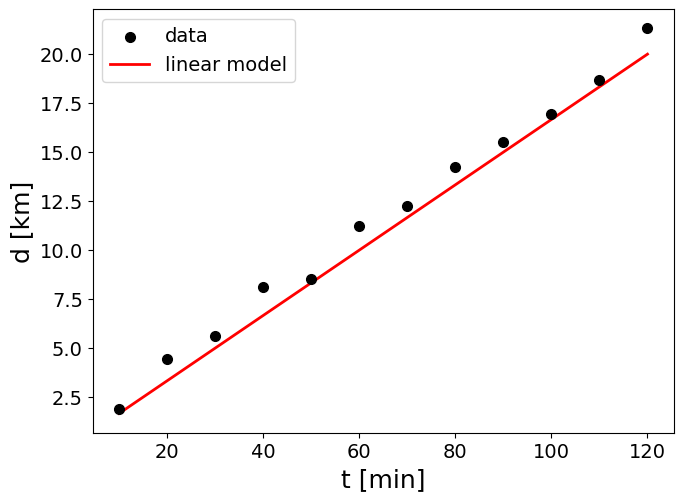

In [26]:
fontsize = 15;

# Plot data and model

# ===============================================
# Test different values for the velocity and see which one fits best!
v =10
# ===============================================

# do an inline plot
pygui(false);

# plot data
scatter(t,d,color = "black",zorder=3, label = "data")
# plot model
plot(t,m(t,v),color = "red",label="linear model")

xlabel("t [min]")
ylabel("d [km]")

legend(loc = "upper left");

The loss function quantifying the deviation between data  $D = \{(t_{1}, d_{1}), (t_{2}, d_{2}),\dots\, (t_{n}, d_{n})\} $ and model $m(t_i,v)$ can be defined as:
\begin{equation}
l(v) = \frac{1}{n}\sum_{i = 1}^n \big( d_{i} - m(t_{i},v) \big)^2 
\end{equation}

\begin{equation}
∇l(v) = \frac{1}{n}\sum_{i = 1}^n \left( \frac{-t_{i}}{60} * 2(d_{i} - m(t_{i},v)) \right) 
\end{equation}

For a given dataset the loss function only depends on the model parameters, in our case the velocity $v$.

In [27]:
# ===============================================
# Define the loss function
loss(v) = sum((d-m(t,v)).^2)
# ===============================================

# ===============================================
# Define the derivative of the loss function
# The loss derivative function is defined for a single d_i and t_i and not for the whole vector d or t
function ∇loss(v)
    inner = -t./60 # column vector for the inner grad
    outer = 2*(d-m(t,v)) # column vector for the outer grad
    return inner' * outer # inner product -> scalar
end
# ===============================================

∇loss (generic function with 1 method)

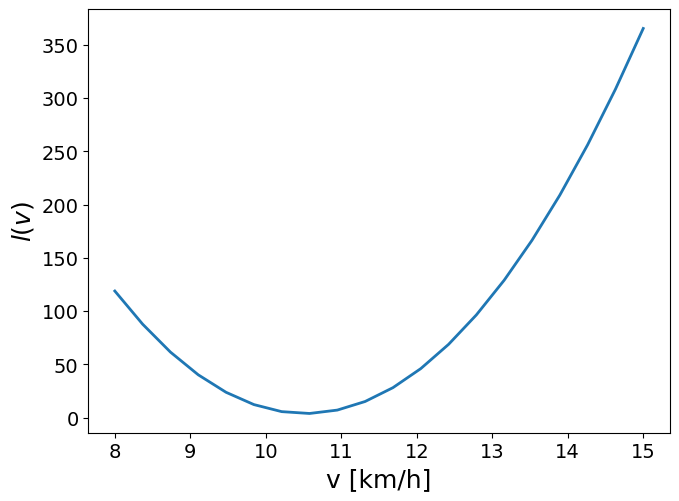

PyObject Text(36.0, 0.5, '$l(v)$')

In [28]:
# plot the loss function

# create values of velocities for which the loss function should be evaluated
test_velocities = range(8,15,length = 20)

# evaluate the loss function for some test velocities
losses = zeros(size(test_velocities,1))
for (index,test) in enumerate(test_velocities)
    losses[index] = loss(test)
end

# evaluate the gradient of the loss function for some test velocities
∇losses = zeros(size(test_velocities,1))
for (index,test) in enumerate(test_velocities)
    ∇losses[index] = ∇loss(test)
end

plot(test_velocities',losses)

xlabel("v [km/h]")
ylabel(L"$l(v)$")

In [29]:
x0 = 1

result,trace = gradient_descent(loss,∇loss, x0, maxiters = 10000, p = 0.5)
println("Optimal velocity [km/h]: ",result)
println("Optimal loss: ",trace[end,end])
println("Gradient at optimum: ",∇loss(result))
println("Iterations: ", size(trace,2)) # --> mistake in the exercise notebook! Corrected here.

Optimal velocity [km/h]: 10.524460831632599
Optimal loss: 3.7956961538551766
Gradient at optimum: -2.5524378370889167e-5
Iterations: 9


In [30]:
println("A real marathon of 42.2 km would take ", round(42.2/result,digits = 2), " hours")

A real marathon of 42.2 km would take 4.01 hours


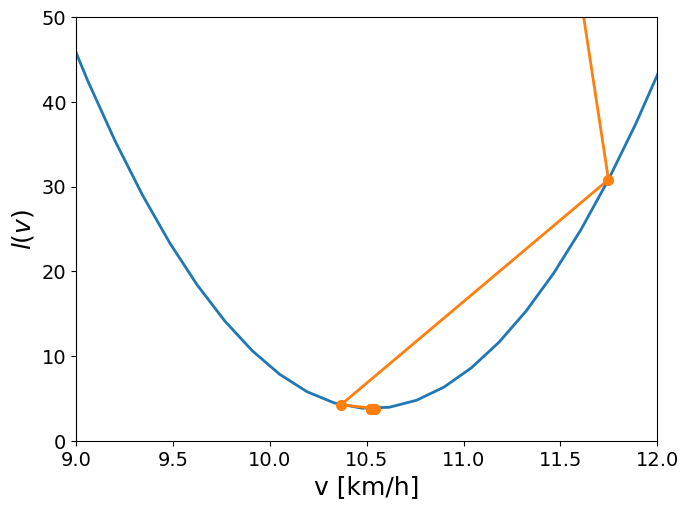

(0.0, 50.0)

In [31]:
# plot the trace

# create values of velocities for which the loss function should be evaluated
test_velocities = range(1,15,length = 100)

# evaluate the loss function for some test velocities
losses = zeros(size(test_velocities,1))
for (index,test) in enumerate(test_velocities)
    losses[index] = loss(test)
end

# evaluate the gradient of the loss function for some test velocities
∇losses = zeros(size(test_velocities,1))
for (index,test) in enumerate(test_velocities)
    ∇losses[index] = ∇loss(test)
end

plot(test_velocities',losses)
plot(trace[1,:],trace[2,:], marker = "o")

xlabel("v [km/h]")
ylabel(L"$l(v)$")

xlim(9,12)
ylim(0,50)